# Field inference for multiple dipole sources

This notebook demonstrates that it is possible to learn analytical forms like the dipole field with good accuracy with a physically credible network and desirable scaling behaviour. In this demonstration, we want to model the potential/field from multiple fixed sources at arbitrary field points, and to do so while running over the sources and inference points separately; i.e. O(M + N) and not O(M * N).

We suppose this to be possible because of the principle of superposition for potentials / fields, and our implementation separately the input of magnetic sources (the 'priming' network) from the inference ('main' network). In particular, we try learning a hypernetwork where the role of the priming network is to output the weights for the main network. We will use jax, equinox and optax to develop a model combining neural and analytical (autodiff) components.

In [1]:
import jax.random as jr
import optax
from hypermagnetics import plots
from hypermagnetics.sources import configure
from hypermagnetics.models.hyper_fourier import FourierModel
from hypermagnetics.runner import fit
# import matplotlib.pyplot as plt
# import scienceplots  # noqa

# plt.style.use(["science", "ieee"])

## I. Target definition and data generation

We expect the neural components of the model to learn transcendental functions. The dipole field at $\mathbf{r}$ from a collection of point-like sources with moments $\mathbf{m}_i$ and positions $\mathbf{r}_i$ is computed via the scalar potential as $${\mu_0}\mathbf{H}_{\odot}(\mathbf{r}) = -\nabla\sum_{i=1}^N \underbrace{\overbrace{\frac{1}{2\pi |\mathbf{r}-\mathbf{r_i}|}}^{\text{Surface of 2D ball}}\overbrace{\frac{\mathbf{m}_i\cdot(\mathbf{r}-\mathbf{r_i})}{|\mathbf{r}-\mathbf{r_i}|}}^{\text{dipole term}}}_{\text{scalar potential }\psi_i}$$. 

A realistic (non-pointlike) source will have, in two dimensions, the form $\mathbf{H}(\mathbf{r}) = - \mathbb{N}(\mathbf{r})\mathbf{M}$ inside the source, and by Gauss' Law $\mathbf{H} \sim \mathbf{H}_\odot$ outside it. The distinguishing feature of the dipole term is the $\sim 1/r$ dependence; higher multipole terms ($1/r^2$, $1/r^3$) might also be included, but the dipole term will quickly dominate at larger $r$. 

We generate random samples to serve as the training data, precomputing the target potential values. Using a fixed training set helps with the stability of training, but we refresh the validation set each time its accuracy computation is needed. First, we describe the collection of sources.

In [2]:
source_config = {
    "n_samples": 1000,
    "n_sources": 1,
    "lim": 3,
    "res": 16,
}
train = configure(**source_config, key=jr.PRNGKey(40))
val = configure(**source_config, key=jr.PRNGKey(41))

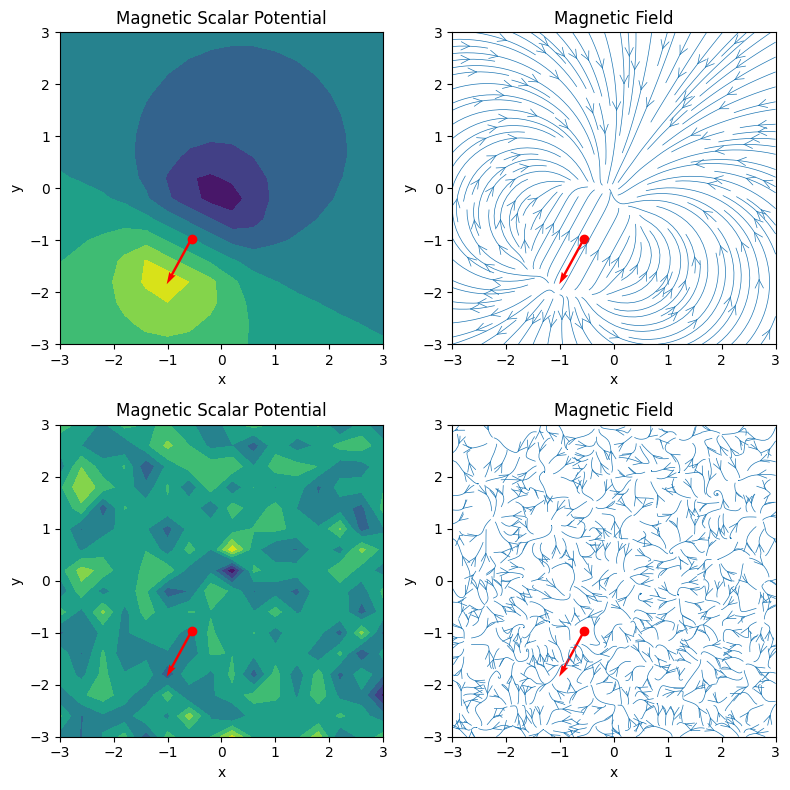

In [3]:
wkey, bkey = jr.split(jr.PRNGKey(41), 2)
model = FourierModel(16, train["grid"], wkey, bkey)
plots(train, model=model)

In [4]:
trainer_config = {"log_learning_rate": -4.0, "epochs": 5000}
learning_rate = 10 ** trainer_config["log_learning_rate"]
optim = optax.adam(learning_rate, b1=0.95)
model = fit(trainer_config, optim, model, train, val, every=100)

{'epoch': 0, 'train_loss': Array(0.48826423, dtype=float32), 'train_acc': Array(1394.5059, dtype=float32), 'val_acc': Array(1309.7537, dtype=float32)}
{'epoch': 100, 'train_loss': Array(0.00122887, dtype=float32), 'train_acc': Array(70.39565, dtype=float32), 'val_acc': Array(77.58286, dtype=float32)}
{'epoch': 200, 'train_loss': Array(0.0004625, dtype=float32), 'train_acc': Array(43.450474, dtype=float32), 'val_acc': Array(58.603077, dtype=float32)}
{'epoch': 300, 'train_loss': Array(0.00031732, dtype=float32), 'train_acc': Array(36.009235, dtype=float32), 'val_acc': Array(54.031075, dtype=float32)}
{'epoch': 400, 'train_loss': Array(0.00023677, dtype=float32), 'train_acc': Array(31.114124, dtype=float32), 'val_acc': Array(51.031868, dtype=float32)}
{'epoch': 500, 'train_loss': Array(0.00018457, dtype=float32), 'train_acc': Array(27.475277, dtype=float32), 'val_acc': Array(48.855896, dtype=float32)}
{'epoch': 600, 'train_loss': Array(0.00014889, dtype=float32), 'train_acc': Array(24.68

In [5]:
print(model.omega_scale)

[11.999807]


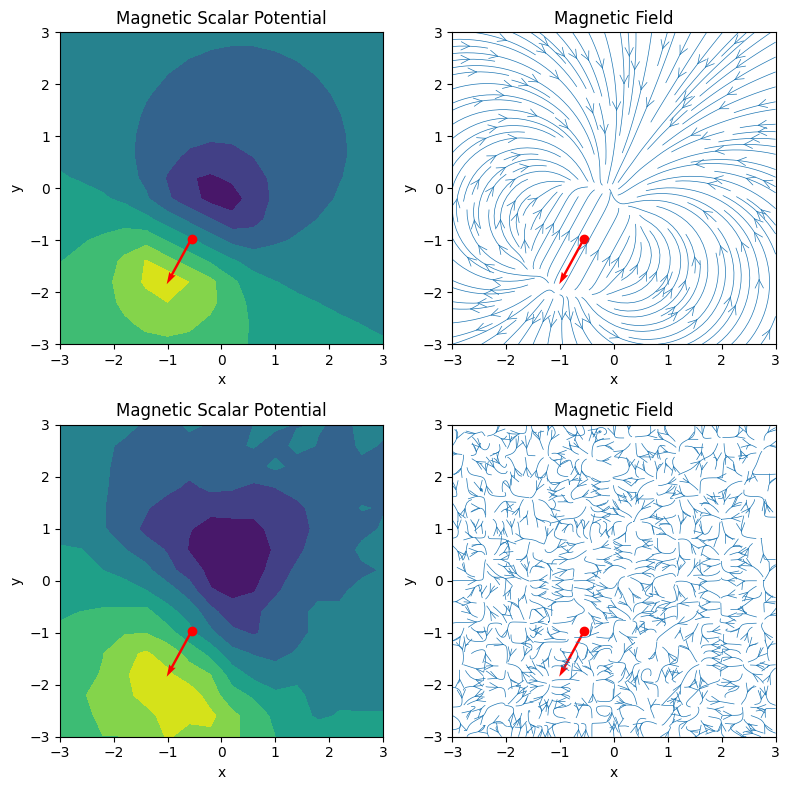

In [6]:
plots(train, model=model)